In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = '*'
os.environ['KAGGLE_KEY'] = '*'

In [ ]:
!kaggle datasets download -d mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out

 99% 2.09G/2.11G [00:22<00:00, 113MB/s] 
100% 2.11G/2.11G [00:22<00:00, 101MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('asl-rgb-depth-fingerspelling-spelling-it-out.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import random

In [ ]:
data_directory = "/content/dataset5/B"
td = "/content/train"
vd = "/content/validation"
ttd = "/content/test"

os.makedirs(td, exist_ok=True)
os.makedirs(vd, exist_ok=True)
os.makedirs(ttd, exist_ok=True)

for folder_name in os.listdir(data_directory):
    folder_path = os.path.join(data_directory, folder_name)
    tsd = os.path.join(td, folder_name)
    vsd = os.path.join(vd, folder_name)
    ttsd = os.path.join(ttd, folder_name)
    os.makedirs(tsd, exist_ok=True)
    os.makedirs(vsd, exist_ok=True)
    os.makedirs(ttsd, exist_ok=True)
    file_list = os.listdir(folder_path)
    random.shuffle(file_list)
    num_files = len(file_list)
    num_train = int(0.7 * num_files)
    num_val = int(0.1 * num_files)
    num_test = int(0.2 * num_files)
    train_files = file_list[:num_train]
    val_files = file_list[num_train:num_train+num_val]
    test_files = file_list[num_train+num_val:num_train+num_val+num_test]
    for file_name in train_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(tsd, file_name)
        shutil.move(src_path, dst_path) 
    for file_name in val_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(vsd, file_name)
        shutil.move(src_path, dst_path)
    for file_name in test_files:
        src_path = os.path.join(folder_path, file_name)
        dst_path = os.path.join(ttsd, file_name)
        shutil.move(src_path, dst_path)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64
PATH = 'model.pth'

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [ ]:
train_dataset = ImageFolder('/content/train', transform=transforms)
validation_dataset = ImageFolder('/content/validation', transform=transforms)
test_dataset = ImageFolder('/content/test', transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
import torchvision as torchvision
model = torchvision.models.resnet18(pretrained=False).to(device)
model.fc = nn.Linear(model.fc.in_features, 24).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
training_loss = []

training_accuracy = []


for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)  
        labels = labels.to(device) 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()
        if (i+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(train_loader)
    epoch_training_accuracy = running_training_accuracy / len(train_loader.dataset)
    training_loss.append(epoch_training_loss)
    training_accuracy.append(epoch_training_accuracy)
    
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy))
    torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [50/305], Loss: 2.3933751583099365
Epoch [1/10], Step [100/305], Loss: 1.6793690919876099
Epoch [1/10], Step [150/305], Loss: 1.668473720550537
Epoch [1/10], Step [200/305], Loss: 1.2053334712982178
Epoch [1/10], Step [250/305], Loss: 1.050215482711792
Epoch [1/10], Step [300/305], Loss: 1.256874680519104
Epoch [1/10], Training Loss: 1.5565907914130415, Training Accuracy: 0.522605836391449
Epoch [2/10], Step [50/305], Loss: 1.0536073446273804
Epoch [2/10], Step [100/305], Loss: 0.6341850161552429
Epoch [2/10], Step [150/305], Loss: 0.7130798101425171
Epoch [2/10], Step [200/305], Loss: 0.4524521231651306
Epoch [2/10], Step [250/305], Loss: 0.4956849217414856
Epoch [2/10], Step [300/305], Loss: 0.5703911781311035
Epoch [2/10], Training Loss: 0.6646014194508068, Training Accuracy: 0.7901253700256348
Epoch [3/10], Step [50/305], Loss: 0.5177069306373596
Epoch [3/10], Step [100/305], Loss: 0.2133682370185852
Epoch [3/10], Step [150/305], Loss: 0.3633493185043335
Epoch [3

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.to('cuda')


model = torch.nn.Sequential(*(list(model.children())[:-1]))

model.eval()


features = []
labels = []
for images, target in train_loader:
    images = images.to('cuda')
    with torch.no_grad():
        output = model(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_features = tsne.fit_transform(features)

target_names = list(train_dataset.class_to_idx.keys())


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19464 samples in 0.005s...
[t-SNE] Computed neighbors for 19464 samples in 14.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19464
[t-SNE] Computed conditional probabilities for sample 2000 / 19464
[t-SNE] Computed conditional probabilities for sample 3000 / 19464
[t-SNE] Computed conditional probabilities for sample 4000 / 19464
[t-SNE] Computed conditional probabilities for sample 5000 / 19464
[t-SNE] Computed conditional probabilities for sample 6000 / 19464
[t-SNE] Computed conditional probabilities for sample 7000 / 19464
[t-SNE] Computed conditional probabilities for sample 8000 / 19464
[t-SNE] Computed conditional probabilities for sample 9000 / 19464
[t-SNE] Computed conditional probabilities for sample 10000 / 19464
[t-SNE] Computed conditional probabilities for sample 11000 / 19464
[t-SNE] Computed conditional probabilities for sample 12000 / 19464
[t-SNE] Computed conditional probabilities for sa

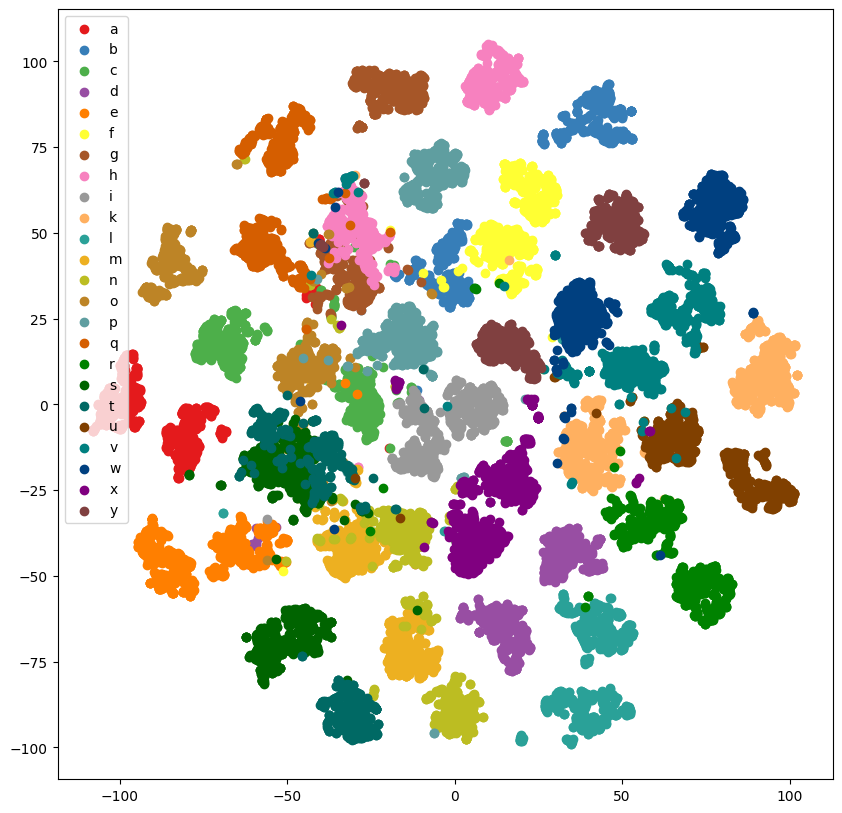

In [ ]:
import matplotlib.colors as mcolors
colors = [
    (0.8941, 0.1020, 0.1098), 
    (0.2157, 0.4941, 0.7216), 
    (0.3020, 0.6863, 0.2902),
    (0.5961, 0.3059, 0.6392), 
    (1.0000, 0.4980, 0.0000), 
    (1.0000, 1.0000, 0.2000), 
    (0.6510, 0.3373, 0.1569), 
    (0.9686, 0.5059, 0.7490), 
    (0.6000, 0.6000, 0.6000),  
    (1.0000, 0.6902, 0.3765), 
    (0.1647, 0.6314, 0.5961), 
    (0.9294, 0.6902, 0.1294), 
    (0.7373, 0.7412, 0.1333),  
    (0.7412, 0.5176, 0.1490),  
    (0.3725, 0.6196, 0.6275), 
    (0.8353, 0.3686, 0.0000),  
    (0.0000, 0.5098, 0.0000), 
    (0.0000, 0.3922, 0.0000),  
    (0.0000, 0.4118, 0.3922),  
    (0.5020, 0.2510, 0.0000),  
    (0.0000, 0.5020, 0.5020),  
    (0.0000, 0.2510, 0.5020),  
    (0.5020, 0.0000, 0.5020),  
    (0.5020, 0.2510, 0.2510),  
]

cmap = mcolors.ListedColormap(colors)


plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    indices = labels == i
    color = cmap(i)  
    plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], color=color, label=target_name)
plt.legend()
plt.show()